# ATAC-seq Analysis

In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2

In [3]:
### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import scipy.stats
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_venn import venn3, venn2
import pickle
from matplotlib import patches as mpatches
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:29: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


## Functions

In [4]:

def get_matched_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
        
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]


    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

## Preprocessing

In [5]:
# file directories
workingDirectory = '/home/jenhan/analysis/atac_analysis/'

genomes = ['hg19','mm10', 'hg38']
scratchDirectory = workingDirectory + '/scratch/'
os.chdir(workingDirectory)



### ATAC-seq

In [6]:

tagDirPath = workingDirectory + '/tag_directories_atac/'

strains = []
treatments = []
owners = []
dates = []
originalNames = []
cellTypes = []
for f in os.listdir(tagDirPath):
    originalName = f
    metaDataTokens = f.split('_')
    
    originalNames.append(originalName)
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip()
    cellType = metaDataTokens[1].strip()
    treatment = metaDataTokens[3].strip().split('-')[0]
    owner = metaDataTokens[5].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    cellTypes.append(cellType)
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes,
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  ]).transpose()
metadata_frame.columns = ['strain', 
                          'Cell Type',
                         'treatment',
                         'owner', 
                         'sampleName']

# ### read in log files ###

# create data frame summarizing mapping quality logs

# from tagInfo.txt
_originalNames =[]
_totalReads = []
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []


for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _originalNames.append(tagdir)
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
        _totalReads.append(float(data[1].split()[2]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 

                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), 
                                                  list(summary_frame['Cell Type'].values), 
                                                  list(summary_frame['treatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics_atac.tsv', sep='\t', index=False)
summary_frame_atac = summary_frame.copy()

## Filter Data on QC Metrics

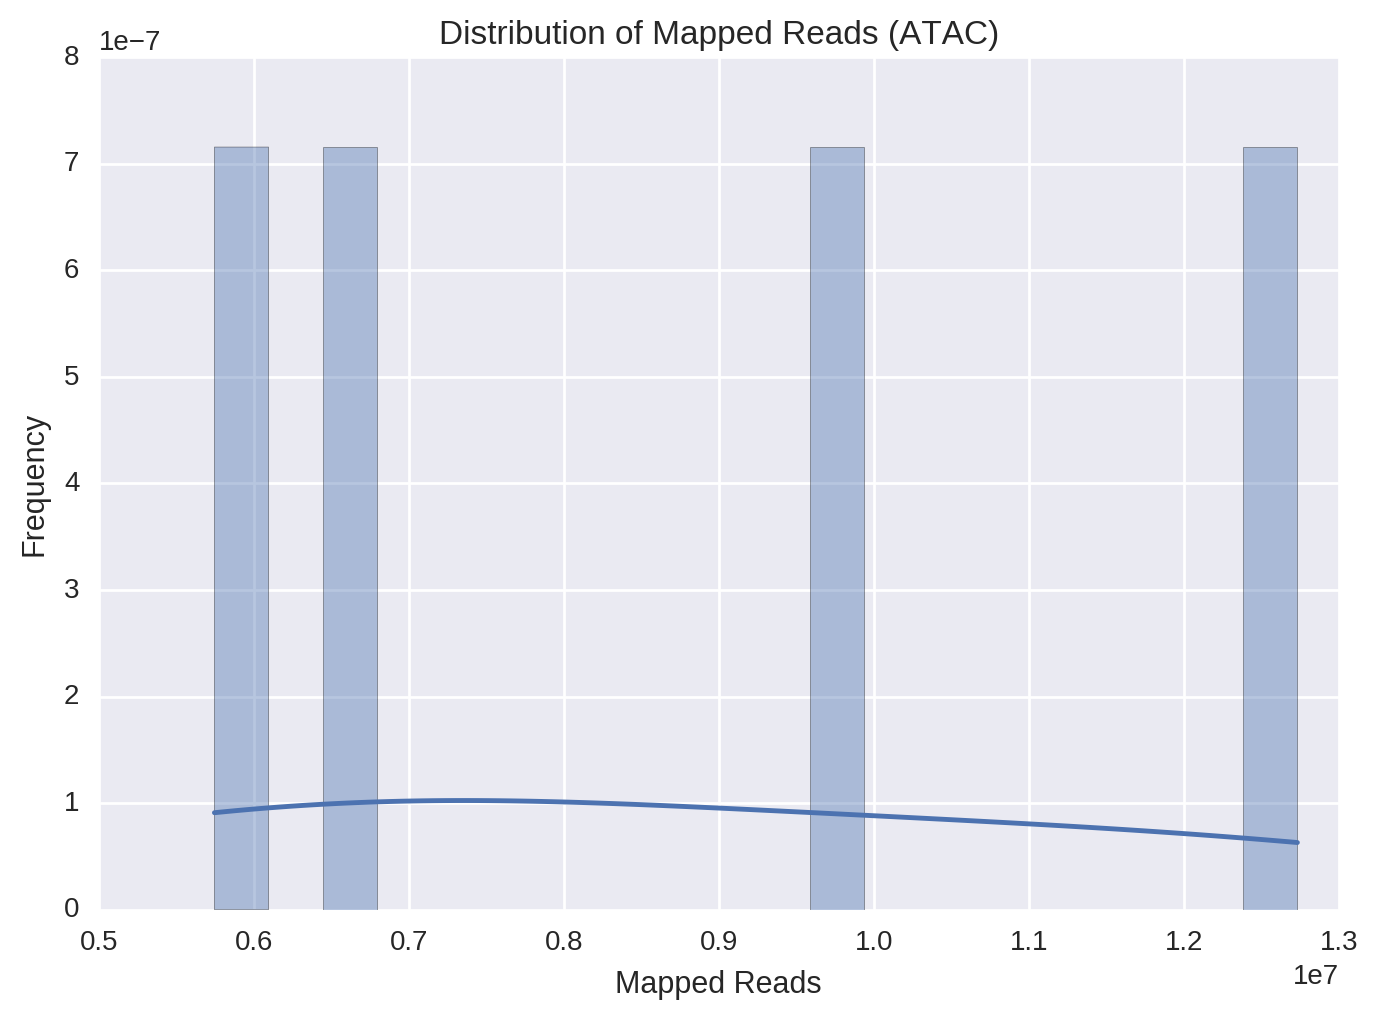

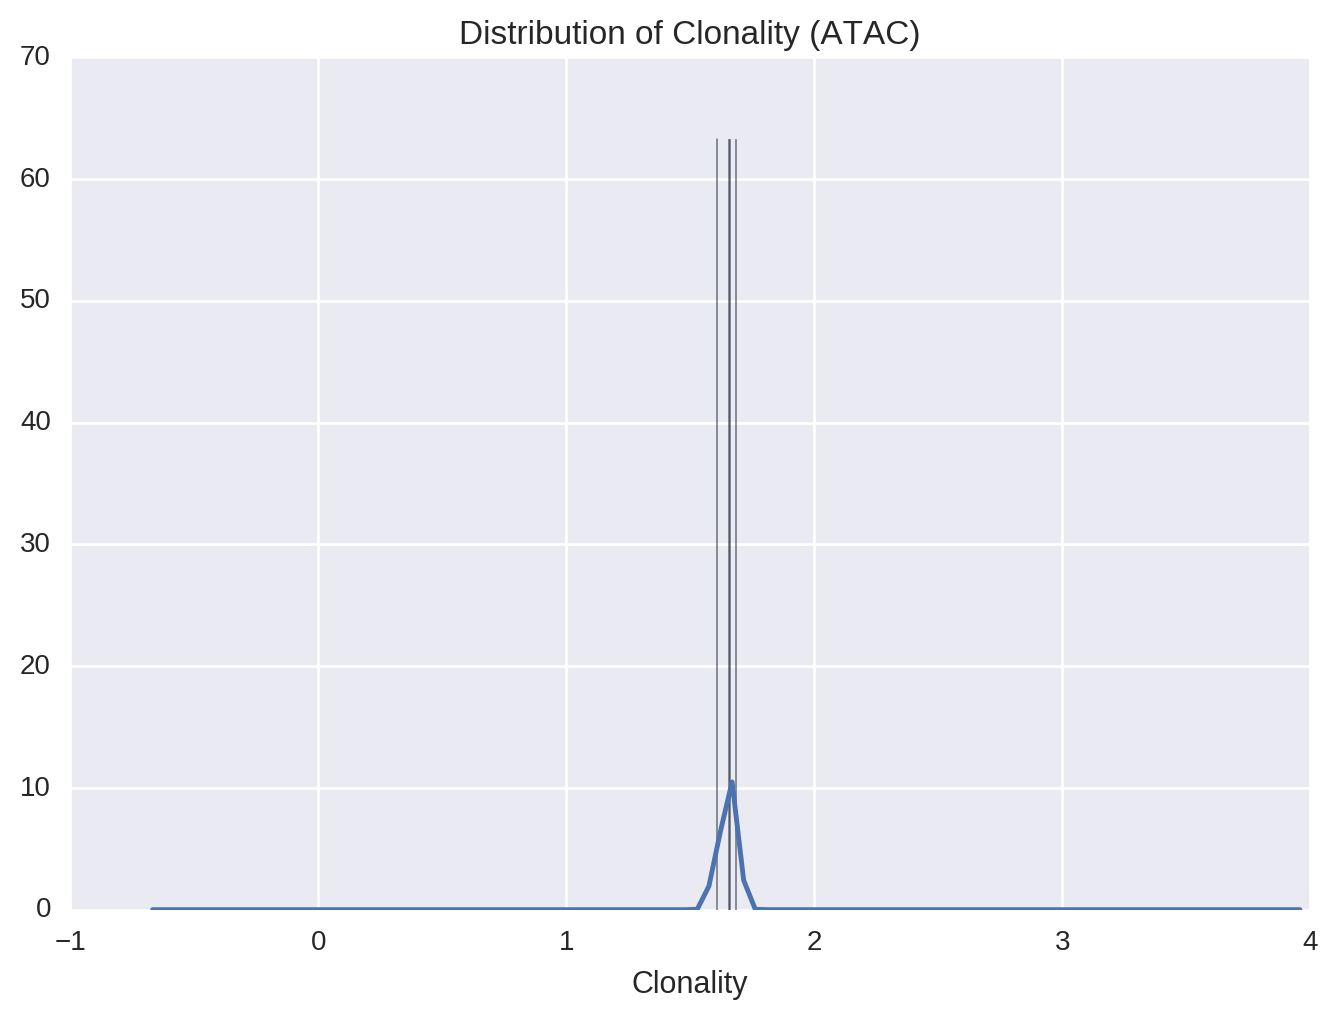

In [9]:
sns.distplot(summary_frame_atac['totalReads'], bins=20, kde=True)
plt.title('Distribution of Mapped Reads (ATAC)')
plt.xlabel('Mapped Reads')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_frame_atac['averageTagsPerPosition'], bins=20)
plt.title('Distribution of Clonality (ATAC)')
plt.xlabel('Clonality')
plt.show()


In [10]:
filtered_summary_frame_atac = summary_frame_atac.copy()

In [11]:
# filter samples according to threshold for the fraction of uniquely mapped reads
readsThreshold = 1000000
pbcThreshold=0.0
# gcThreshold=0.10
clonalityThreshold = 20
# spotThreshold = 0.005


## ATAC-seq Peak Calling

In [16]:
### call peaks ###
peakDirectory = '/home/jenhan/analysis/atac_analysis/peak_files'
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names

for sn in filtered_summary_frame_atac['sampleName'].values:
    
    peakFileName = sn + "_peaks.tsv"

    print('findPeaks ' + tagDirPath + '/' + sn + 
                     ' -L 0 -C 0 -fdr 0.9' +
                     ' -style factor -size 200 -minDist 200  > ' + 
                     peakDirectory +'/' + peakFileName + ' &')



findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200 -minDist 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200 -minDist 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200 -minDist 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11 -L 0 -C 0 -fdr 0.9 -style factor -size 200 -minDist 200  > /home/jenhan/analysis/atac

In [126]:
%%bash
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200 -minDist 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200 -minDist 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11 -L 0 -C 0 -fdr 0.9 -style factor -size 200 -minDist 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200 -minDist 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv &

	Fragment Length = 67
	Total Tags = 12733303.0
	Tags per bp = 0.006367
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 200
	Fragment Length = 67
	Total Tags = 6737504.0
	Tags per bp = 0.003369
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 200
	Fragment Length = 77
	Total Tags = 9726543.0
	Tags per bp = 0.004863
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 200
	Fragment Length = 67
	Total Tags = 5746574.0
	Tags per bp = 0.002873
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 200
		Finding peaks on chr1 (minCount=-0.3), total tags positions = 317898
		Finding peaks on chr1 (minCount=-0.4), total tags positions = 273690
		Finding peaks on chr2 (minCount=-0.3), total tags positions = 298232
		Finding peaks on chr2 (minCount=-0.4), total tags positions = 267441
		Finding peaks on chr1 (minCount=-0.0), total tags positions = 448119
		Findin

### Run IDR

In [ ]:
! rm ./idr_atac/*
idrDirectory = '/home/jenhan/analysis/atac_analysis/idr_atac/'

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi

replicateIndices = []
for index in set(filtered_summary_frame_atac.index):
    factor_treatment_rows = filtered_summary_frame_atac.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
for ri in replicateIndices:
    samples = filtered_summary_frame_atac.ix[ri, 'sampleName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            !echo "python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory &"
            

python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/idr_atac/ &
python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/idr_atac/ &


In [ ]:
%%bash
python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/idr_atac/ &
python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/idr_atac/ &

In [ ]:
idrDirectory = '/home/jenhan/analysis/atac_analysis/idr_atac/'
count_dict = {}
for f in os.listdir(idrDirectory):
    if 'idr.tsv' in f:
        tokens = f.split('_')
        strain = tokens[0]
        cellType = tokens[1]
        treatment = tokens[3].split('-')[0]
        condition = '_'.join([strain, cellType, treatment])
        with open(idrDirectory + f) as file:
            data = file.readlines()
        numPeaks = len(data) - 1
        if not condition in count_dict:
            count_dict[condition] = (f, numPeaks)
        else:
            if numPeaks > count_dict[condition][1]:
                count_dict[condition] = (f, numPeaks)        
for key in count_dict:
    idrResult = count_dict[key][0]
    peakFileName = key+'_peaks.tsv'

    !echo cp $idrDirectory/$idrResult ./idr_peak_files/$peakFileName
    !cp $idrDirectory/$idrResult ./idr_peak_files/$peakFileName

### Merge peak files

In [12]:
! mergePeaks -d given -venn venn.txt ./idr_peak_files/* > ./merged_peaks.tsv
! makeSummaryFile.py ./merged_peaks.tsv ./group_summary.tsv ./idr_peak_files/*

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing ./idr_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv (59388 total) and ./idr_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv (59388 total)
	Comparing ./idr_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv (59388 total) and ./idr_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv (34035 total)
	Comparing ./idr_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv (34035 total) and ./idr_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv (59388 total)
	Comparing ./idr_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv (34035 total) and ./idr_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv (34035 total)

Finished reading merged peak file...
Integrating scores for C57Bl6_Thiomac_KLA
Integrating scores for C57Bl6_Thiomac_Veh


In [13]:
# read in peak data data
peak_frame = pd.read_csv('./group_summary.tsv' , sep='\t')
peak_frame = peak_frame.fillna('0')
for col in peak_frame.columns[5:]:
    floatValues = []
    for val in peak_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.max([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    peak_frame[col] = floatValues
peak_frame.index = peak_frame['ID'].values

# remove peaks in unknown/random chromosomes
peak_frame = peak_frame[~peak_frame['chr'].str.contains('random')]
peak_frame = peak_frame[~peak_frame['chr'].str.contains('Un')]



### Create background peaks from genomic sequences from each chromosome

In [15]:
! if [ ! -d ./group_by_chromosome ]; then mkdir ./group_by_chromosome; fi
! rm -rf ./group_by_chromosome/*


In [16]:
peakSize = 200 # size of artificial background peaks
N_threshold = 0.5 # throw away background peaks containing greater than this fraction of N

tile_peak_file = open('./group/merged_tile_peaks.tsv','w')

tile_peak_file.write('\t'.join(['#ID', 'chr', 'start', 'end', 'strand\n']))

for f in os.listdir('./mm10_genome/'):
    if '.fa' in f and not f in ['chrY.fa', 'chrM.fa'] :
        current_chromosome = f.split('.')[0]
        
        # create seperate peak file containing just this chromosome
        if not os.path.isdir('./group_by_chromosome/'+current_chromosome):
            os.mkdir('./group_by_chromosome/'+current_chromosome)
        current_tile_peak_file = open(
            './group_by_chromosome/'+ current_chromosome + '/' + current_chromosome +'_tile_peaks.tsv','w')
        current_tile_peak_file.write('\t'.join(['#ID', 'chr', 'start', 'end', 'strand\n']))
        
        # read in fastq file line by line
        with open('./mm10_genome/' + f) as chromosome_file:
            data = chromosome_file.readlines()
        genome_seq = ''
        for line in data[1:]:
            genome_seq += line.strip().upper()
        genome_seq_size = len(genome_seq)
        
        # create array indicating if position is N
        is_N = [True if x == 'N' else False for x in genome_seq]

        # create array indicating if position overlaps with a peak
        # simultaneously write ATAC-seq peaks
        is_peak = [False for x in genome_seq]
        current_peak_frame = peak_frame[(peak_frame['chr'] == current_chromosome) &
                                        (peak_frame['Factors'].str.contains('Veh'))] # only work with vehicle peaks for now
        print(current_chromosome, current_peak_frame.shape)
        positions = list(zip(current_peak_frame['ID'].values, current_peak_frame['start'].values, current_peak_frame['end'].values))
        for pos in positions:
            
            ID = pos[0]
            start = pos[1] - 1
            end = pos[2]
            for i in range(start, end):
                is_peak[i] = True
            tile_peak_file.write('\t'.join([ID, current_chromosome, str(start), str(end), '+\n']))  
            current_tile_peak_file.write('\t'.join([ID, current_chromosome, str(start), str(end), '+\n']))  
        
        # write background peak files
        for i in range(0,genome_seq_size, peakSize):
            n_count = np.sum(is_N[i:i+peakSize+1])
            if not n_count > peakSize * N_threshold:
                if not np.sum(is_peak[i:i+peakSize+1]) > 0:
                    tile_peak_file.write('\t'.join(['tile_'+str(i), current_chromosome, str(i), str(i+peakSize), '+\n']))        
                    current_tile_peak_file.write('\t'.join([current_chromosome + '_tile_'+str(i), current_chromosome, str(i), str(i+peakSize), '+\n']))        

        current_tile_peak_file.close()
tile_peak_file.close()  

chr19 (964, 7)
chr6 (1989, 7)
chr7 (1997, 7)
chr18 (1183, 7)
chr5 (1910, 7)
chr4 (1940, 7)
chr1 (2480, 7)
chr3 (2144, 7)
chr2 (2649, 7)
chr14 (1300, 7)
chrX (820, 7)
chr15 (1385, 7)
chr17 (1345, 7)
chr8 (1692, 7)
chr9 (1710, 7)
chr16 (1266, 7)
chr12 (1478, 7)
chr13 (1848, 7)
chr11 (1782, 7)
chr10 (2084, 7)


### Extract genomic sequences for each set of peak files

In [17]:
peakDirectory =  './group_by_chromosome/'
for chrom in os.listdir(peakDirectory):
    peakPath = peakDirectory + chrom + '/' + chrom + '_tile_peaks.tsv'
    seqPath = peakPath.replace('_peaks.tsv','.fa')
    !homerTools extract $peakPath /bioinformatics/homer/data/genomes/mm10 -fa > $seqPath

    


	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 757817 sequences from chr4

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 632682 sequences from chr10

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 816421 sequences from chrX

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 456834 sequences from chr17

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 603627 sequences from chr9

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 779297 sequences from chr3

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 706716 sequences from chr7

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 289762 sequences from chr19

	Extracting sequences from directory: /bioinformatic

## Scan Peaks for Motifs

In [18]:
# create a script to scan for motifs using FIMO
! if [ ! -d ./fimo_results/ ]; then mkdir ./fimo_results/; fi
! if [ ! -d ./fimo_out/ ]; then mkdir ./fimo_out/; fi


pthresh = 0.01
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'
fimo_results_dir = './fimo_results'


peakDirectory =  './group_by_chromosome/'
for chrom in os.listdir(peakDirectory):
    scriptFile = open('scanMotifs_' + chrom + '.sh','w')
    for m in os.listdir(motif_dir):
        fimo_out_dir = './fimo_out/' + chrom + '_' + m.replace('.fimo','')

        if 'fimo' in m:
            outPath = fimo_results_dir + '/' +chrom + '_'+ m.replace('.fimo','') +'.txt'
            scriptFile.write(
                'fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
                str(pthresh)  + ' ' +
                motif_dir + '/' + m + ' ./group_by_chromosome/' + chrom + '/' + chrom + '_tile.fa ' +
                '> ' + outPath + ' & \n')
    scriptFile.close()





In [19]:
%%bash
chmod a+x ./scanMotifs*.sh
for i in ./scanMotifs*sh; 
    do echo 'sleeping...';
    echo $i;
    $i;
    sleep 5m;
done


sleeping...
./scanMotifs_chr10.sh
sleeping...
./scanMotifs_chr11.sh
sleeping...
./scanMotifs_chr12.sh
sleeping...
./scanMotifs_chr13.sh
sleeping...
./scanMotifs_chr14.sh
sleeping...
./scanMotifs_chr15.sh
sleeping...
./scanMotifs_chr16.sh
sleeping...
./scanMotifs_chr17.sh
sleeping...
./scanMotifs_chr18.sh
sleeping...
./scanMotifs_chr19.sh
sleeping...
./scanMotifs_chr1.sh
sleeping...
./scanMotifs_chr2.sh
sleeping...
./scanMotifs_chr3.sh
sleeping...
./scanMotifs_chr4.sh
sleeping...
./scanMotifs_chr5.sh
sleeping...
./scanMotifs_chr6.sh
sleeping...
./scanMotifs_chr7.sh
sleeping...
./scanMotifs_chr8.sh
sleeping...
./scanMotifs_chr9.sh
sleeping...
./scanMotifs_chrX.sh


Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Using motif +dmbx1 of width 17.
Using motif +spz1 of width 11.
Using motif -spz1 of width 11.
Using motif -dmbx1 of width 17.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Using motif +dux4 of width 11.
Using motif -dux4 of width 11.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Using motif +hoxa5 of width 8.
Using motif -hoxa5 of width 8.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
U

## Read in Score Files

### Motif Scores

In [20]:
###  create pickles for each chromosome
! if [ ! -d ./pickles ]; then mkdir ./pickles; fi
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'

peakDirectory =  './group_by_chromosome/'
scaler = preprocessing.MinMaxScaler()


for chrom in sorted(os.listdir(peakDirectory)):
    peak_frame = pd.read_csv('./group_by_chromosome/' + chrom + '/' + chrom + '_tile_peaks.tsv', sep='\t')
    columns = peak_frame.columns.values
    columns[0] = 'ID'
    peak_frame.columns = columns
    peak_frame['Factors'] = ['atac' if not 'tile' in x else 'tile' for x in peak_frame['ID'].values]
    
#     peak_start_dict = dict(zip(peak_frame['ID'].values, peak_frame['start'].values))

    motif_score_frame = peak_frame[['ID', 'Factors', 'chr']]
    motif_score_frame.index=motif_score_frame['ID'].values

#     motif_sequence_frame = peak_frame[['ID', 'Factors', 'chr']]
#     motif_sequence_frame.index=motif_score_frame['ID'].values

#     motif_strand_frame = peak_frame[['ID', 'Factors', 'chr']]
#     motif_strand_frame.index=motif_score_frame['ID'].values

#     motif_start_frame = peak_frame[['ID', 'Factors', 'chr']]
#     motif_start_frame.index=motif_score_frame['ID'].values

#     motif_end_frame = peak_frame[['ID', 'Factors', 'chr']]
#     motif_end_frame.index=motif_score_frame['ID'].values

#     motif_count_frame = peak_frame[['ID', 'Factors', 'chr']]
#     motif_count_frame.index = motif_count_frame['ID'].values

    counter=0
    for m in sorted(os.listdir(motif_dir)):
        counter+=1

        if '.fimo' in m:
            print(chrom, counter,m)
            motif_results = './fimo_results/' + chrom + '_' + m.replace('.fimo','') +'.txt'
            fimo_result_frame=pd.read_csv(motif_results, 
                                          skiprows=1,
                                          names=['motif_name', 
                                                 'peak_id', 
                                                 'start', 
                                                 'stop', 
                                                 'strand', 
                                                 'score', 
                                                 'pvalue', 
                                                 'sequence'],
                                          sep='\t')
            motif_name = m.replace('.fimo','')
            id_score_dict = {}
#             id_strand_dict = {}
#             id_sequence_dict = {}
#             id_start_dict = {}
#             id_end_dict = {}
#             id_count_dict = {}
            
            ids = fimo_result_frame['peak_id'].values
            scores = fimo_result_frame['score'].values
#             strands = fimo_result_frame['strand'].values
#             sequences = fimo_result_frame['sequence']
#             starts = fimo_result_frame['start']
#             ends = fimo_result_frame['stop']

            for i in range(len(ids)):
                currentScore = float(scores[i])
#                 currentSequence = sequences[i]
#                 currentStrand = strands[i]
#                 currentStart = int(starts[i])
#                 currentEnd = int(ends[i])
                if currentScore < 0.0:
                    currentScore = 0.0
                if ids[i] in id_score_dict:
                    if currentScore > id_score_dict[ids[i]]:
                        id_score_dict[ids[i]] = currentScore
#                         id_sequence_dict[ids[i]] = currentSequence
#                         id_strand_dict[ids[i]] = currentStrand
#                         id_start_dict[ids[i]] = currentStart
#                         id_end_dict[ids[i]] = currentEnd
#                         id_count_dict[ids[i]] += 1
                else:
                    id_score_dict[ids[i]] = currentScore
#                     id_sequence_dict[ids[i]] = currentSequence
#                     id_strand_dict[ids[i]] = currentStrand
#                     id_start_dict[ids[i]] = currentStart
#                     id_end_dict[ids[i]] = currentEnd
#                     id_count_dict[ids[i]] = 0

            motif_score_frame[motif_name] = [id_score_dict[x] if x in id_score_dict else 0 for x in motif_score_frame['ID'].values]
#             motif_sequence_frame[motif_name] = [id_sequence_dict[x] if x in id_sequence_dict else '?' for x in motif_sequence_frame['ID'].values]
#             motif_strand_frame[motif_name] = [id_strand_dict[x] if x in id_score_dict else '' for x in motif_strand_frame['ID'].values]
#             motif_start_frame[motif_name] = [id_start_dict[x] + peak_start_dict[x] if x in id_start_dict else -1 for x in motif_start_frame['ID'].values]
#             motif_end_frame[motif_name] = [id_end_dict[x] + peak_start_dict[x] if x in id_end_dict else -1 for x in motif_end_frame['ID'].values]
#             motif_count_frame[motif_name] = [id_count_dict[x] if x in id_count_dict else 0 for x in motif_count_frame['ID'].values]

    motif_score_frame.to_pickle('./pickles/' + chrom + '_motif_score_frame.pickle')

#     motif_sequence_frame.to_pickle('./pickles/' + chrom + '_motif_sequence_frame.pickle')

#     motif_strand_frame.to_pickle('./pickles/' + chrom + '_motif_strand_frame.pickle')

#     motif_start_frame.to_pickle('./pickles/' + chrom + '_motif_start_frame.pickle')

#     motif_end_frame.to_pickle('./pickles/' + chrom + '_motif_end_frame.pickle')

#     motif_count_frame.to_pickle('./pickles/' + chrom + '_motif_count_frame.pickle')

    normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
    normed_motif_frame.columns = motif_score_frame.columns.values[3:]
    normed_motif_frame.index = motif_score_frame.index.values
    
    normed_motif_frame.to_pickle('./pickles/' + chrom + '_normed_motif_frame.pickle')

chr1 2 alx1_alx4_arx.fimo
chr1 3 ap-1.fimo
chr1 4 ar_nr3c1_nr3c2.fimo
chr1 5 arid3a.fimo
chr1 6 arid3b.fimo
chr1 7 arid5a.fimo
chr1 8 arnt_mycn.fimo
chr1 9 arntl_mitf.fimo
chr1 10 ascl2_nhlh1.fimo
chr1 11 atf7_batf3_creb5.fimo
chr1 12 bcl6.fimo
chr1 13 bcl6b.fimo
chr1 14 bhlh.fimo
chr1 15 bhlha15.fimo
chr1 16 bhlhe23.fimo
chr1 17 cdx.fimo
chr1 18 cebp.fimo
chr1 19 cenpb.fimo
chr1 20 creb3-l1.fimo
chr1 21 crem.fimo
chr1 22 ctcf.fimo
chr1 23 cux.fimo
chr1 24 dbp_hlf_tef.fimo
chr1 25 dmbx1.fimo
chr1 26 dmrt3.fimo
chr1 27 dux.fimo
chr1 28 dux4.fimo
chr1 29 duxa.fimo
chr1 30 e2f1.fimo
chr1 31 e2f2.fimo
chr1 32 e2f4_e2f6.fimo
chr1 33 e2f7.fimo
chr1 34 e2f8.fimo
chr1 35 ebf1.fimo
chr1 36 ebox.fimo
chr1 37 egr.fimo
chr1 38 elf.fimo
chr1 39 elk_etv.fimo
chr1 40 esr1.fimo
chr1 41 esr2.fimo
chr1 42 esrr.fimo
chr1 43 ewsr1-fli1.fimo
chr1 44 figla_id4_snai2_tcf3_tcf4.fimo
chr1 45 fox.fimo
chr1 46 gata.fimo
chr1 47 gcm.fimo
chr1 48 gfi1.fimo
chr1 49 gfi1b.fimo
chr1 50 gli2.fimo
chr1 51 glis.fimo
chr

## Logistic Regression on all Chromosomes

In [21]:
chromosome_coeff_dict = {} # store coefficients for each chromosome {trainingChromosome:{testChromosome:[coefficients]}}
chromosome_probas_dict = {} # probabilities for each locus {trainingChromosome:{testChromosome:[probas]}}
chromosome_rocAUC_dict = {} # ROC AUC for each chromosome {trainingChromosome:{testChromosome:auc}}
chromosome_prAUC_dict = {}
peakDirectory = './group_by_chromosome/'
chromosomes = sorted(os.listdir(peakDirectory))
for training_chromosome in chromosomes:
    training_features = pd.read_pickle('./pickles/' + training_chromosome + '_normed_motif_frame.pickle')
    training_labels = [False if 'tile' in x else True for x in training_features.index.values]

    #  train classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    lr_classifier.fit(training_features, training_labels)

    # initialize sub dictionaries to store results
    chromosome_probas_dict[training_chromosome] = {}
    chromosome_rocAUC_dict[training_chromosome] = {}
    chromosome_prAUC_dict[training_chromosome] = {}
    
    coefficients = lr_classifier.coef_

    chromosome_coeff_dict[training_chromosome] = coefficients.flatten()
    for chrom in chromosomes:
        print('training on ', training_chromosome, 'testing on ', chrom)
        if not chrom == training_chromosome:
            test_features = pd.read_pickle('./pickles/' + chrom + '_normed_motif_frame.pickle')
            test_labels = [False if 'tile' in x else True for x in test_features.index.values]

            probas_lr = lr_classifier.predict_proba(test_features)

            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
            
            precision, recall, thresholds = sklearn.metrics.precision_recall_curve(test_labels, probas_lr[:, 1])
            
            roc_auc = auc(fpr, tpr) # calculate area under the curve
            pr_auc = auc(recall, precision)
            
            
            chromosome_probas_dict[training_chromosome][chrom] = probas_lr[:,1]
            chromosome_rocAUC_dict[training_chromosome][chrom] = roc_auc
            chromosome_prAUC_dict[training_chromosome][chrom] = pr_auc

            print(training_chromosome, chrom, roc_auc, pr_auc)
motifs = training_features.columns.values

training on  chr1 testing on  chr1
training on  chr1 testing on  chr10
chr1 chr10 0.970243041902 0.403462094146
training on  chr1 testing on  chr11
chr1 chr11 0.971258706813 0.437662054684
training on  chr1 testing on  chr12
chr1 chr12 0.967603345275 0.33508062234
training on  chr1 testing on  chr13
chr1 chr13 0.960285500933 0.332330641053
training on  chr1 testing on  chr14
chr1 chr14 0.971966768158 0.355216655196
training on  chr1 testing on  chr15
chr1 chr15 0.970657885872 0.391986424239
training on  chr1 testing on  chr16
chr1 chr16 0.971054003027 0.385842652165
training on  chr1 testing on  chr17
chr1 chr17 0.967248962819 0.378665413736
training on  chr1 testing on  chr18
chr1 chr18 0.966060376908 0.345431730266
training on  chr1 testing on  chr19
chr1 chr19 0.975728063484 0.434762225123
training on  chr1 testing on  chr2
chr1 chr2 0.969383593667 0.389530358
training on  chr1 testing on  chr3
chr1 chr3 0.970662351663 0.354604328071
training on  chr1 testing on  chr4
chr1 chr4 0.97

In [22]:
pickle.dump(chromosome_coeff_dict, open('chromosome_coeff_dict.pickle','wb'))
pickle.dump(chromosome_probas_dict, open('chromosome_probas_dict.pickle','wb'))
pickle.dump(chromosome_rocAUC_dict, open('chromosome_rocAUC_dict.pickle','wb'))
pickle.dump(chromosome_prAUC_dict, open('chromosome_prAUC_dict.pickle','wb'))

## Summarize Performance

### Visualize Correlations

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn-0.7.0-py3.4.egg/seaborn/matrix.py:134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn-0.7.0-py3.4.egg/seaborn/matrix.py:142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


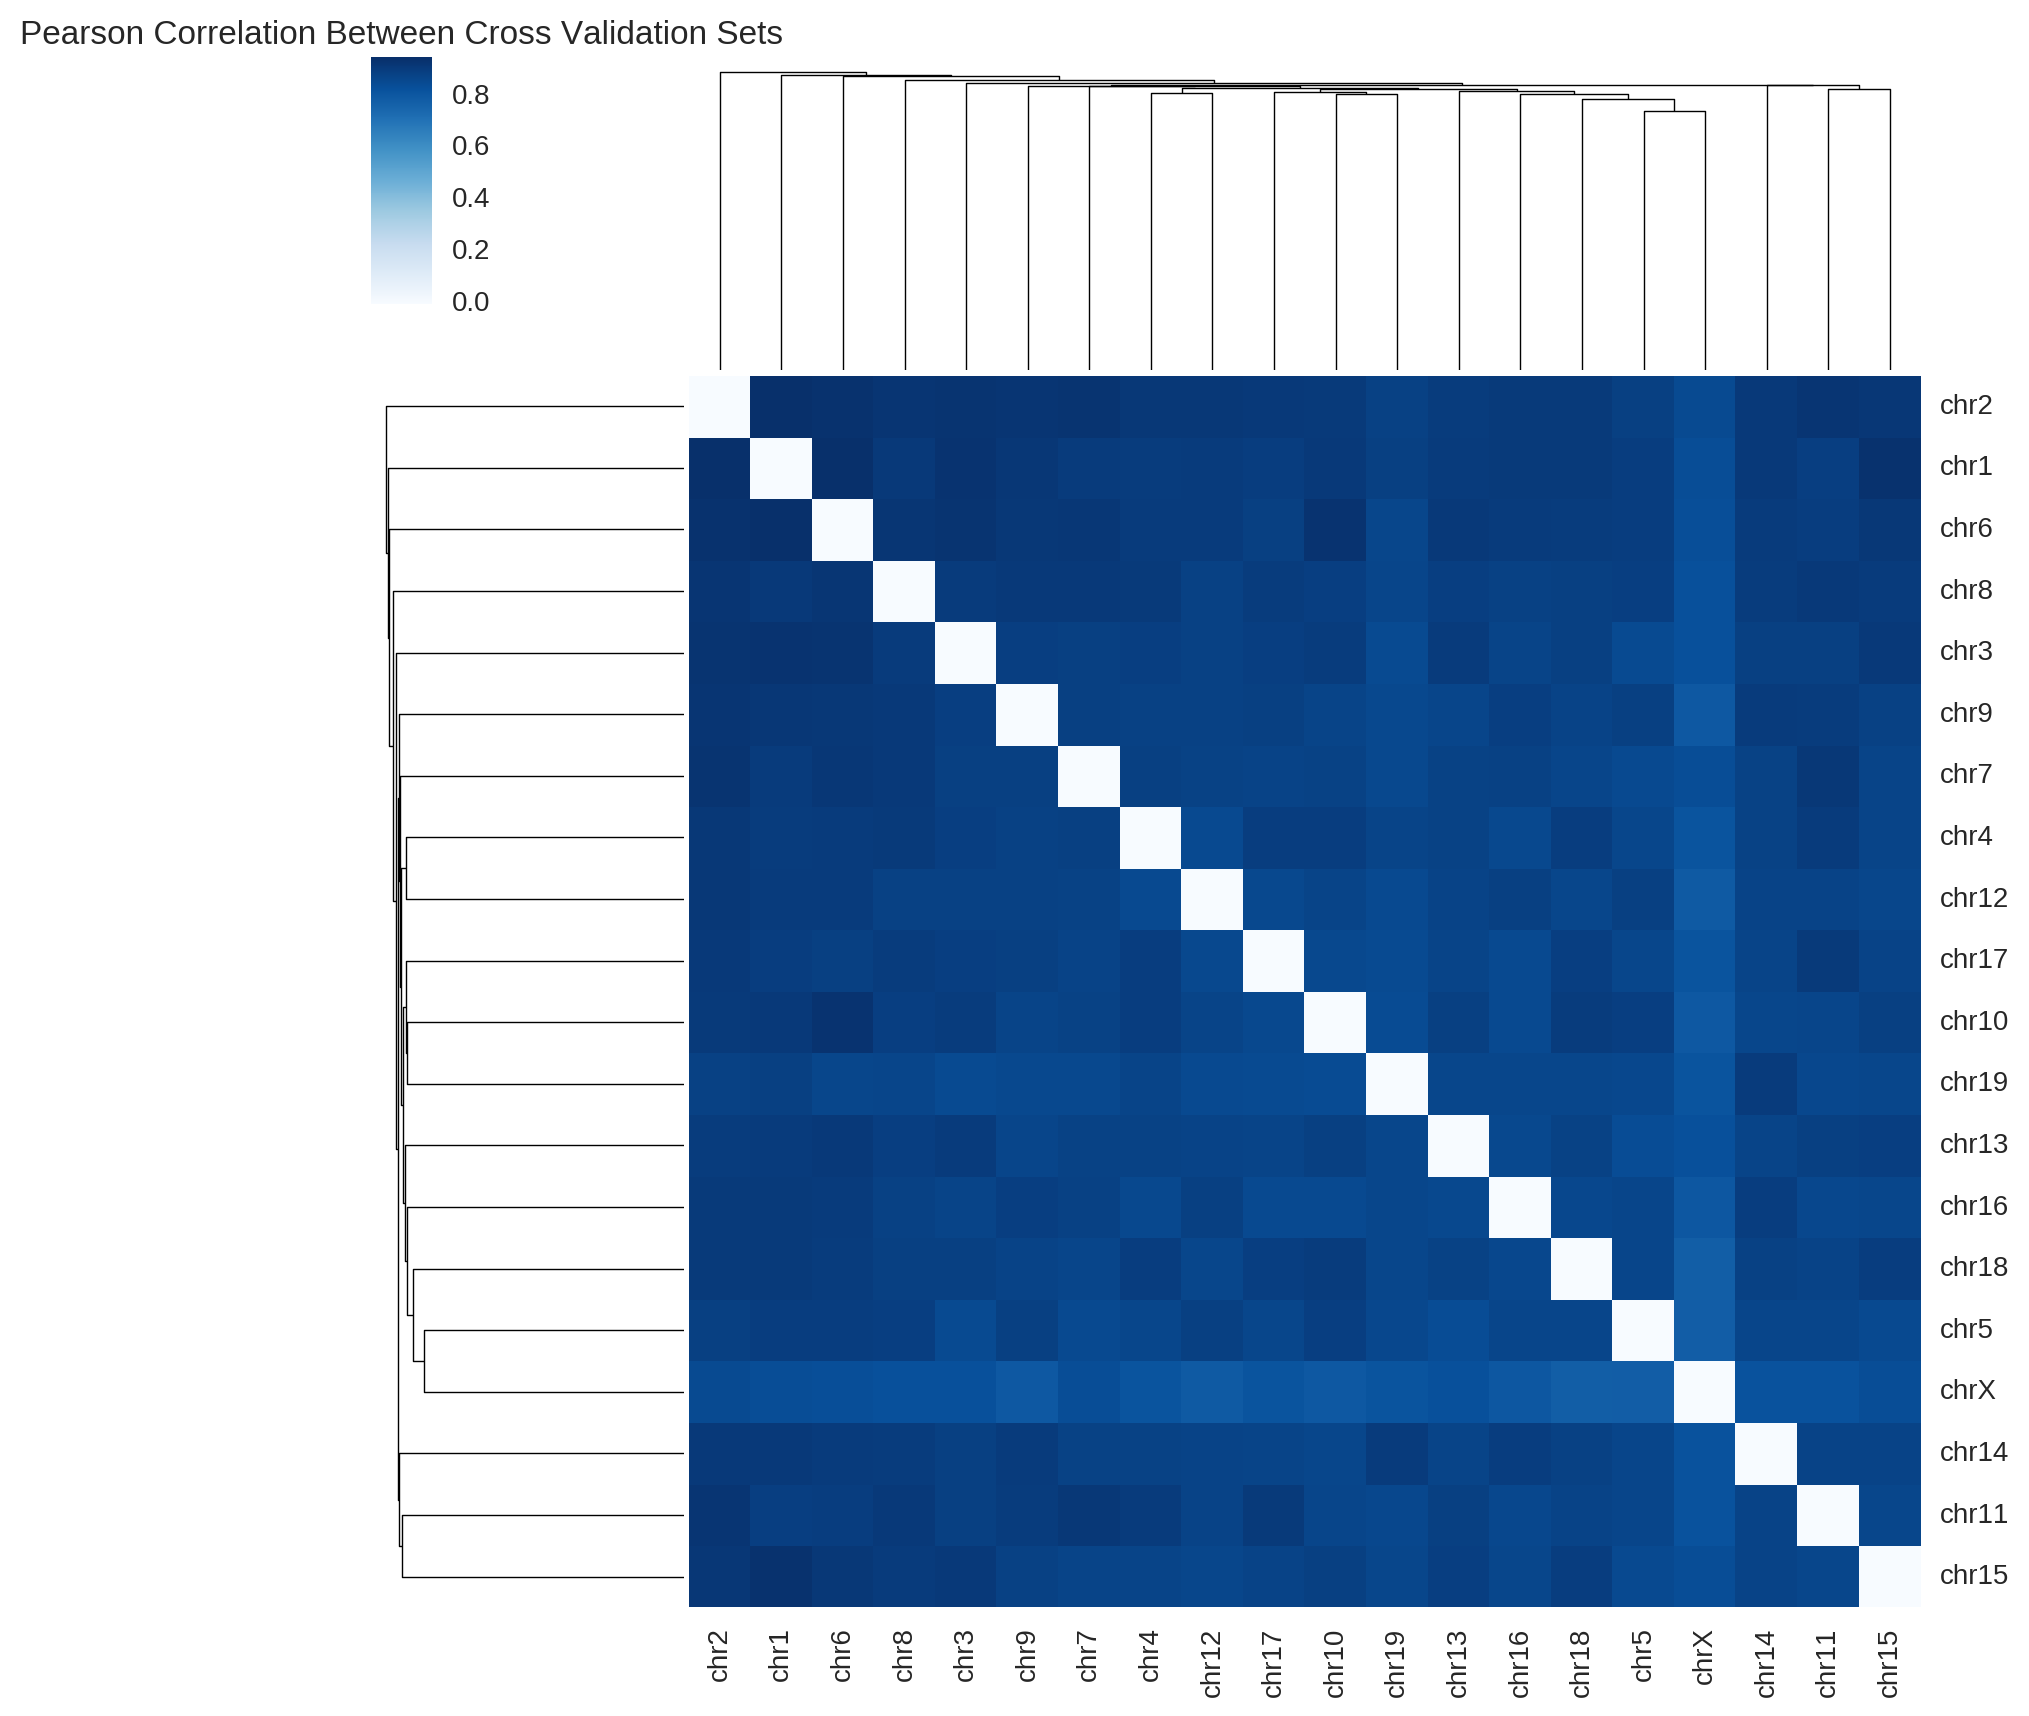

In [23]:
###Show Correlation Between Test Validation Sets
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
               'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX'
              ]

    
chromosome_index_dict = dict(zip(chromosomes, range(len(chromosomes))))

corr_matrix = np.zeros((len(chromosomes), len(chromosomes)))
for i in range(len(chromosomes) - 1):
    training_chromosome_1 = chromosomes[i]
    index_1 = chromosome_index_dict[training_chromosome_1]
    for j in range(i+1, len(chromosomes)):
        training_chromosome_2 = chromosomes[j]
        index_2 = chromosome_index_dict[training_chromosome_2]
        pearson, pvalue = scipy.stats.pearsonr(chromosome_coeff_dict[training_chromosome_1],
                                              chromosome_coeff_dict[training_chromosome_2])
        corr_matrix[index_1][index_2] = pearson
        corr_matrix[index_2][index_1] = pearson

cg = sns.clustermap(data=corr_matrix, cmap='Blues', xticklabels = chromosomes, yticklabels = chromosomes)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.title("Pearson Correlation Between Cross Validation Sets")

### Visualize rocAUC

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

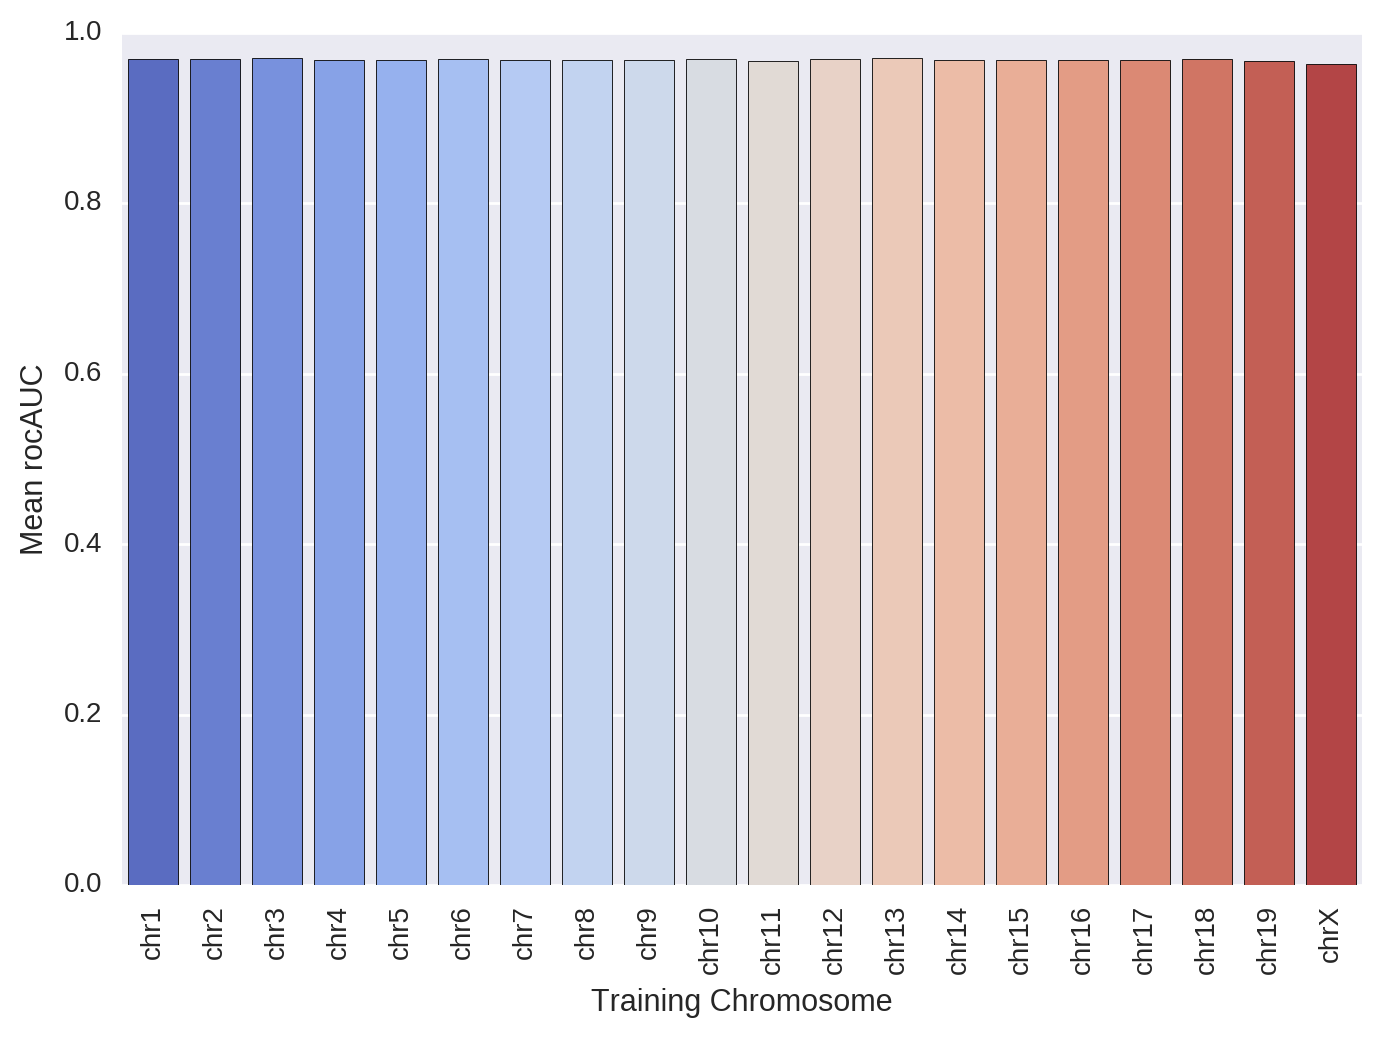

In [24]:
### Show AUCs as a training X test X AUC heatmap
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
               'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX'
              ]
roc_matrix = np.zeros((len(chromosomes), len(chromosomes)))
for i in range(len(chromosomes)):
    training_chromosome = chromosomes[i]
    for j in range(len(chromosomes)):
        if not i==j:
            test_chromosome = chromosomes[j]
            roc_matrix[i][j] = chromosome_rocAUC_dict[training_chromosome][test_chromosome]

pr_matrix = np.zeros((len(chromosomes), len(chromosomes)))
for i in range(len(chromosomes)):
    training_chromosome = chromosomes[i]
    for j in range(len(chromosomes)):
        if not i==j:
            test_chromosome = chromosomes[j]
            pr_matrix[i][j] = chromosome_prAUC_dict[training_chromosome][test_chromosome]
            

data = pd.DataFrame({'Training Chromosome': chromosomes, 
                         'mean aucROC':roc_matrix.sum(axis=1)/(len(chromosomes)-1)})

sns.barplot(data=data, x='Training Chromosome', y='mean aucROC', palette = 'coolwarm')
plt.ylabel('Mean rocAUC')
# plt.gca().set_xticklabels(chromosomes)
plt.xticks(rotation=90)
# plt.xlabel('Training Chromosome')

### Visualize prAUC

(0, 1)

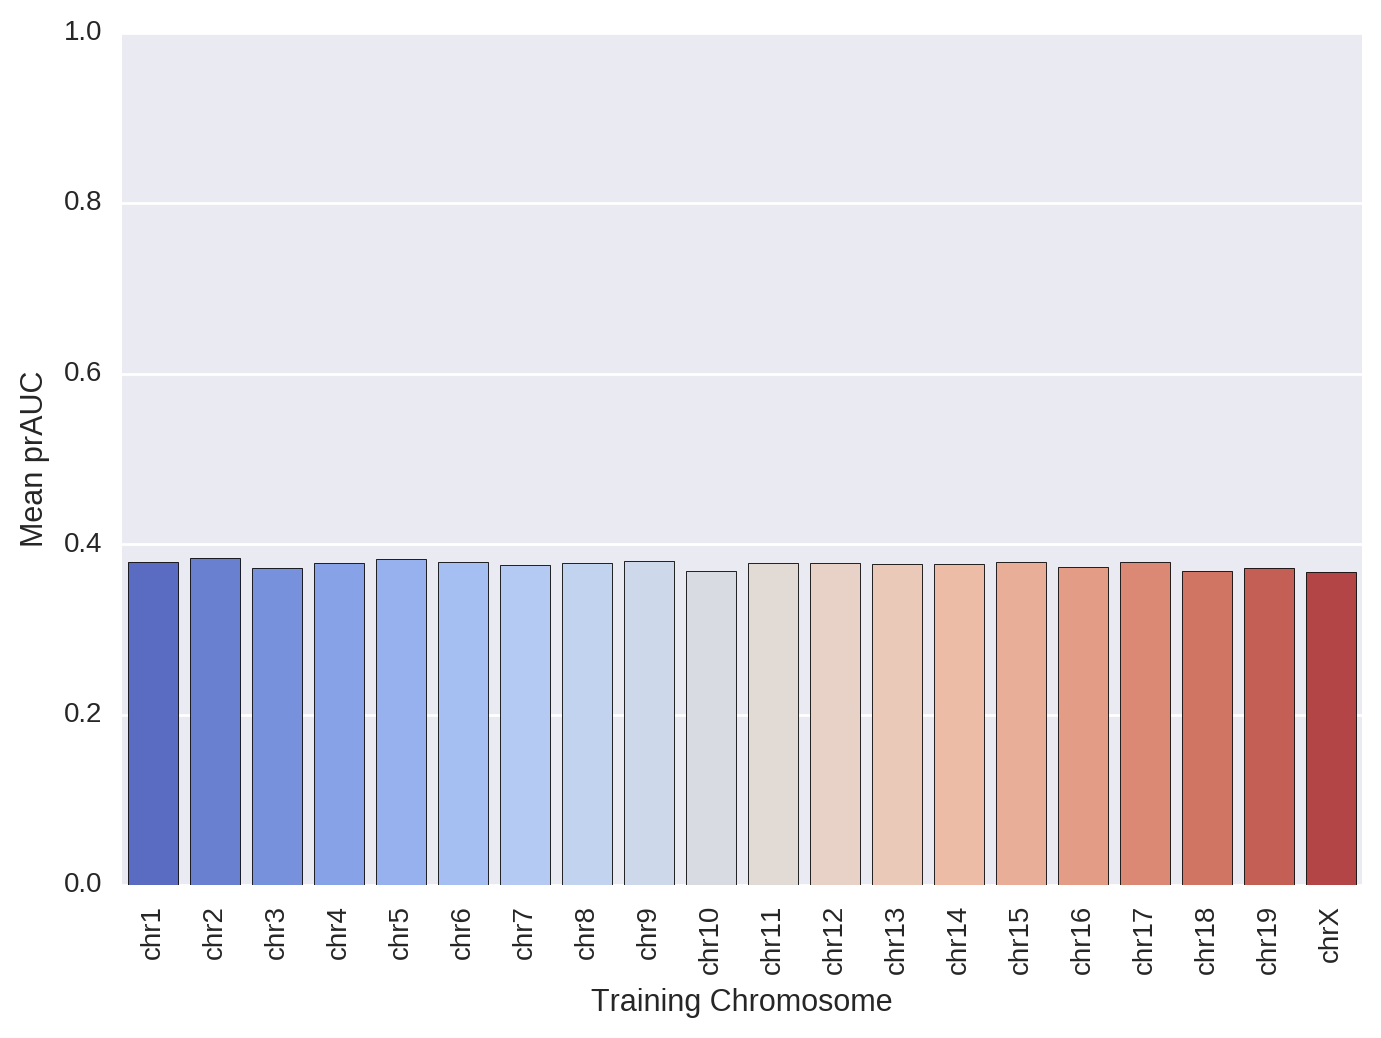

In [33]:
### Show AUCs as a training X test X AUC heatmap
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
               'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX'
              ]

# sns.heatmap(matrix,
#            xticklabels = chromosomes,
#            yticklabels = chromosomes,
#            cmap='Blues',
# #            annot=True,
# #            fmt='g',
#            vmin=0,
#            vmax=1.0
#            )
# plt.xlabel('Training Chromosome')        
# plt.ylabel('Test Chromosome')
# plt.title('ROC AUC')

data = pd.DataFrame({'Training Chromosome': chromosomes, 
                         'mean prAUC':pr_matrix.sum(axis=1)/(len(chromosomes)-1)})

sns.barplot(data=data, x='Training Chromosome', y='mean prAUC', palette = 'coolwarm')
plt.ylabel('Mean prAUC')
# plt.gca().set_xticklabels(chromosomes)
plt.xticks(rotation=90)
plt.ylim(0,1)
# plt.xlabel('Training Chromosome')

In [ ]:
### Create bedGraph Track

# average probabilities across all training/test sets
chromosomes = sorted(os.listdir(peakDirectory))

chromosome_meanProbas_dict = {} # {chromosome:[meanProbas]}

for test_chromosome in chromosomes:
    probas = []
    for training_chromosome in chromosomes:
        if not test_chromosome == training_chromosome:
            probas.append(chromosome_probas_dict[training_chromosome][test_chromosome])
    mean_probas = np.mean(probas, axis=0)
    chromosome_meanProbas_dict[test_chromosome] = mean_probas


        

In [ ]:
! if [ ! -d ./bedgraph ]; then mkdir ./bedgraph; fi
! rm ./bedgraph/*
scalingFactor = 100
bedgraph_file = open('./bedgraph/scores.bedgraph', 'w')
bedgraph_file.write('track type=bedGraph name="Classifier Scores" description="Probs * 100"\n')
for chrom in chromosomes:
    current_bedgraph_file = open('./bedgraph/'+chrom + '.bedgraph', 'w')
    current_bedgraph_file.write('track type=bedGraph name="' + chrom +' Scores" description="Probs * 100"\n')
    print(chrom)
    with open('./group_by_chromosome/' + chrom + '/' + chrom + '_tile_peaks.tsv') as f:
        data = f.readlines()
    
    probas = chromosome_meanProbas_dict[chrom]
    print(np.sum(probas>0.5))
    data = data[1:-1]
    for i in range(len(data)):
            if probas[i] > 0.01:
                tokens = data[i].split('\t')
                chrom = tokens[1]
                start = tokens[2]
                end = tokens[3]
                prob = str(probas[i] * scalingFactor)
                bedgraph_file.write('\t'.join([chrom, start, end, prob]) + '\n')
                current_bedgraph_file.write('\t'.join([chrom, start, end, prob]) + '\n')


    current_bedgraph_file.close()
bedgraph_file.close()

In [ ]:
!pos2bed.pl ./idr_peak_files/C57Bl6_Thiomac_Veh_peaks.tsv > ./bedgraph/C57Bl6_Thiomac_Veh_peaks.bed
!pos2bed.pl ./idr_peak_files/C57Bl6_Thiomac_KLA_peaks.tsv > ./bedgraph/C57Bl6_Thiomac_KLA_peaks.bed

### Show Top Motifs

In [ ]:
### Show Top Motifs

# average coeffs across all training/test sets
chromosomes = sorted(os.listdir(peakDirectory))

chromosome_meanCoeffs_dict = {} # {chromosome:[meanCoeffs]}

coeffs = []
for training_chromosome in chromosomes:
    coeffs.append(chromosome_coeff_dict[test_chromosome])
mean_coeffs = np.mean(coeffs, axis=0)
chromosome_meanCoeffs_dict[test_chromosome] = mean_coeffs

coefficients_frame = pd.DataFrame({'Weight':mean_coeffs})
coefficients_frame.index = motifs
    


In [ ]:
coeff

In [ ]:
threshold = 1.4

factor_motifs_dict = {}
significant_motifs = set()
for factor in coefficients_frame.columns.values:
    weights = coefficients_frame[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs.add(m)

In [ ]:
sns.distplot(coefficients_frame['Weight'].values, bins=50)
plt.xlabel('Weight Magnitude')
plt.ylabel('Frequency (KDE)')

In [ ]:

data = coefficients_frame[coefficients_frame.index.isin(significant_motifs)]

# fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style('whitegrid'):
    data['Motif'] = data.index.values
    data.columns = ['Weight', 'Motif']
    data = data.sort('Weight')
    sns.factorplot(data = data, x= 'Motif', y='Weight', size=4, kind='bar', palette='coolwarm')
    plt.xticks(rotation=90)

## Predictions with Top Motifs

In [ ]:
motif_features = sorted(significant_motifs)

significant_chromosome_coeff_dict = {} # store coefficients for each chromosome {trainingChromosome:{testChromosome:[coefficients]}}
significant_chromosome_probas_dict = {} # probabilities for each locus {trainingChromosome:{testChromosome:[probas]}}
significant_chromosome_rocAUC_dict = {} # ROC AUC for each chromosome {trainingChromosome:{testChromosome:auc}}
significant_chromosome_prAUC_dict = {}
peakDirectory = './group_by_chromosome/'
chromosomes = sorted(os.listdir(peakDirectory))

for training_chromosome in chromosomes:
    training_features = pd.read_pickle('./pickles/' + training_chromosome + '_normed_motif_frame.pickle')
    training_features = training_features[motif_features]
    training_labels = [False if 'tile' in x else True for x in training_features.index.values]

    #  train classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    lr_classifier.fit(training_features, training_labels)

    # initialize sub dictionaries to store results
    significant_chromosome_probas_dict[training_chromosome] = {}
    significant_chromosome_rocAUC_dict[training_chromosome] = {}
    significant_chromosome_prAUC_dict[training_chromosome] = {}

    coefficients = lr_classifier.coef_

    significant_chromosome_coeff_dict[training_chromosome] = coefficients.flatten()
    for chrom in chromosomes:
        print('training on ', training_chromosome, 'testing on ', chrom)
        if not chrom == training_chromosome:
            test_features = pd.read_pickle('./pickles/' + chrom + '_normed_motif_frame.pickle')
            test_features = test_features[motif_features]
            test_labels = [False if 'tile' in x else True for x in test_features.index.values]

            probas_lr = lr_classifier.predict_proba(test_features)

            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
            precision, recall, thresholds = sklearn.metrics.precision_recall_curve(test_labels, probas_lr[:, 1])

#             roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1])
#             pr_auc = sklearn.metrics.precision_score(test_labels, probas_lr[:, 1] > 0.5)
            
            roc_auc = auc(fpr, tpr) # calculate area under the curve
            pr_auc = auc(recall, precision)
            
            
            significant_chromosome_probas_dict[training_chromosome][chrom] = probas_lr[:,1]
            significant_chromosome_rocAUC_dict[training_chromosome][chrom] = roc_auc
            significant_chromosome_prAUC_dict[training_chromosome][chrom] = pr_auc

            print(training_chromosome, chrom, roc_auc, pr_auc)


## comparison between different cell types

In [46]:
chromosome_coeff_dict_thiomac = pickle.load(open('/home/jenhan/analysis/atac_analysis/chromosome_coeff_dict.pickle', 'rb'))
chromosome_coeff_dict_kupffer = pickle.load(open('/home/jenhan/analysis/atac_analysis_kupffer/chromosome_coeff_dict.pickle', 'rb'))
chromosome_coeff_dict_microgila = pickle.load(open('/home/jenhan/analysis/atac_analysis_microglia/chromosome_coeff_dict.pickle', 'rb'))
chromosome_coeff_dict_eyeCone = pickle.load(open('/home/jenhan/analysis/atac_analysis_eyeCone/chromosome_coeff_dict.pickle', 'rb'))
chromosome_coeff_dict_eyeRod = pickle.load(open('/home/jenhan/analysis/atac_analysis_eyeRod/chromosome_coeff_dict.pickle', 'rb'))

In [48]:
chromosomes = sorted(os.listdir('./group_by_chromosome/'))

cellType_coefficients_dict = {}

coeffs = []
for training_chromosome in chromosomes:
    coeffs.append(chromosome_coeff_dict_thiomac[training_chromosome])
mean_coeffs = np.mean(coeffs, axis=0)
cellType_coefficients_dict['Thiomac'] = mean_coeffs

coeffs = []
for training_chromosome in chromosomes:
    coeffs.append(chromosome_coeff_dict_kupffer[training_chromosome])
mean_coeffs = np.mean(coeffs, axis=0)
cellType_coefficients_dict['Kupffer'] = mean_coeffs

coeffs = []
for training_chromosome in chromosomes:
    coeffs.append(chromosome_coeff_dict_microgila[training_chromosome])
mean_coeffs = np.mean(coeffs, axis=0)
cellType_coefficients_dict['Microglia'] = mean_coeffs

coeffs = []
for training_chromosome in chromosomes:
    coeffs.append(chromosome_coeff_dict_eyeCone[training_chromosome])
mean_coeffs = np.mean(coeffs, axis=0)
cellType_coefficients_dict['Cone'] = mean_coeffs

coeffs = []
for training_chromosome in chromosomes:
    coeffs.append(chromosome_coeff_dict_eyeRod[training_chromosome])
mean_coeffs = np.mean(coeffs, axis=0)
cellType_coefficients_dict['Rod'] = mean_coeffs

In [51]:
cellType_coefficients_frame = pd.DataFrame(cellType_coefficients_dict, index=motifs)

In [64]:
threshold = 2.0
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
significant_motifs = set()
for factor in cellType_coefficients_frame.columns.values:
    weights = cellType_coefficients_frame[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs.add(m)
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits


Cone -1.11382277386 1.60059769775
Kupffer -0.951350961224 1.84801767191
Microglia -1.09583060536 1.68349297934
Rod -1.15935358362 1.53473133587
Thiomac -1.03823927763 1.97348372727


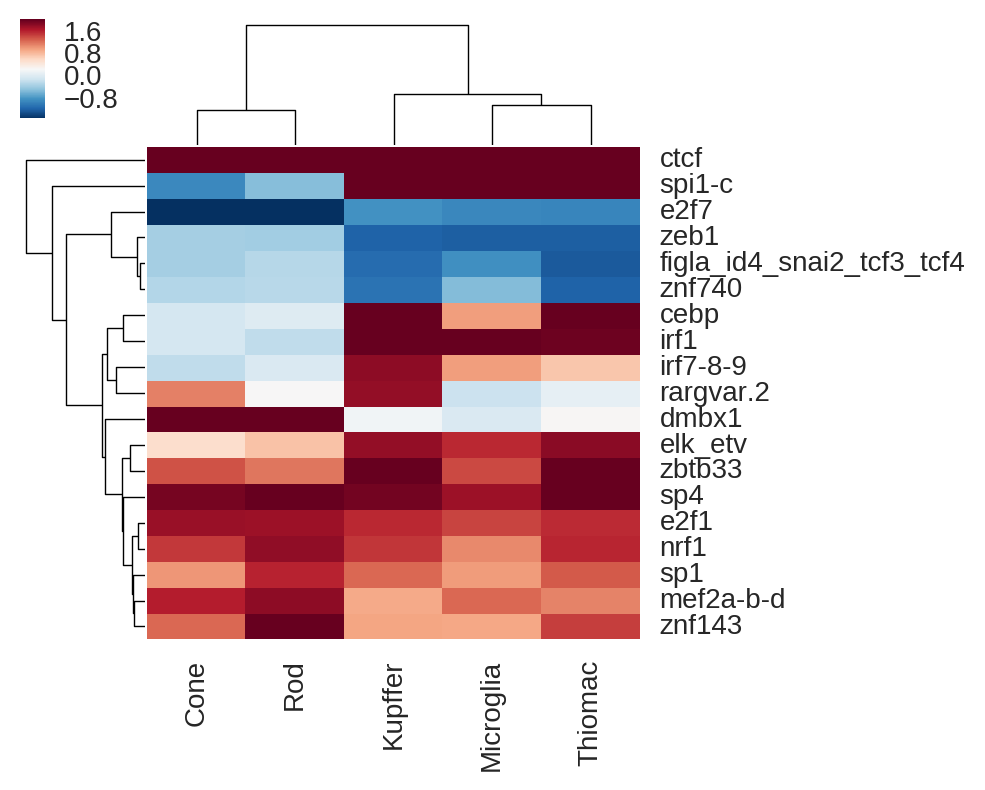

In [67]:
threshold = 2.5
coeff_std = np.std(cellType_coefficients_frame.values.flatten())
coeff_mean = np.mean(cellType_coefficients_frame.values.flatten())
data = cellType_coefficients_frame[cellType_coefficients_frame.index.isin(significant_motifs)]
cg = sns.clustermap(data,
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=False,annot_kws={"size": 8},
                   figsize=(4,4)
                   )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);